# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.12.0'

## Import the Data

In [3]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [4]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [5]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [6]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [8]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [10]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [11]:
x_train.shape

(60000, 784)

In [12]:
x_test.shape

(10000, 784)

## Reshape the labels

In [13]:
y_train.shape

(60000,)

In [14]:
y_test.shape

(10000,)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [16]:
num_classes = len(np.unique(y_train))
num_classes

10

In [17]:
y_train_ = np.zeros((len(y_train), num_classes))
y_test_ = np.zeros((len(y_test), num_classes))

In [18]:
y_train_[np.arange(len(y_train)), y_train] = 1
y_test_[np.arange(len(y_test)), y_test] = 1

In [19]:
y_train=y_train_
y_test=y_test_

In [20]:
y_train.shape

(60000, 10)

In [21]:
y_test.shape

(10000, 10)

In [22]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

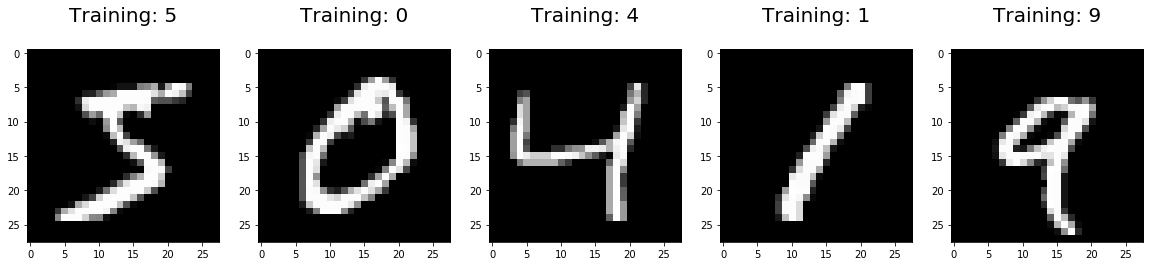

In [23]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [24]:
# print info every n_print
n_print = 1

# hidden layer 1
n1=300

## Defined our model

In [25]:
# x [60000, 784]
# y [60000, 10]

# 1 layer n1 with 200 neurones
# n1 = 300

#  . . . . . .    input data (ffattened pixels)      x [batch    ,   dim_input]
#   \x/\x/x/      -- fully connected layer (relu)    W1[dim_input,          n1]      B1[n1         ]
#    . . .                                           Y1[batch    ,          n1]
#     \x/         -- fully connected layer (softmax) W2[n1       , num_classes]      B2[num_classes]
#      .                                             Y2[batch    , num_classes]

# reset graph before starting
tf.reset_default_graph()

# tensor (placeholder) for the learning rate
learning_rate = tf.placeholder(tf.float32, shape=())

# tensor (placeholder) for the input data [60000, 784]
x = tf.placeholder(tf.float32, [None, dim_input])

# tensor (placeholder) for the output data [60000, 10]
y = tf.placeholder(tf.float32, [None, num_classes])

# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([dim_input, n1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n1]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([n1, num_classes], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([num_classes]), name='b2')

# initialization for W
#tf.Variable(tf.random_normal([], stddev = stddev))
#tf.Variable(tf.truncated_normal([], stddev = stddev))

# initialization for b
#tf.Variable(tf.constant(0.0, shape = []))
#tf.Variable(tf.random_normal([], stddev = stddev))

# calculate the output of the hidden layer
Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

# last layer
Ylogits= tf.matmul(Y1, W2) + b2

# output layer
y_ = tf.nn.softmax(Ylogits)

# now let's define the cost function which we are going to train the model on

# cross entropy defined manually
# -sum(y * log(y_) + (1-y) * log(1-y_))
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999) # if value are below 1e-10 return 1e-10 same of 0.9999999
cross_entropy = tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1)
cost = -tf.reduce_mean(cross_entropy)

# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# finally setup the initialisation operator
init= tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, test_obs, test_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history_train = np.empty(shape=[0], dtype = float)
    cost_history_test = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        
        sess.run(optimiser, feed_dict = {x: train_obs, y: train_labels, learning_rate: learning_r})

        cost_train = sess.run(cost, feed_dict={x: train_obs, y: train_labels, learning_rate: learning_r})
        cost_history_train = np.append(cost_history_train, cost_train)
        
        cost_test = sess.run(cost, feed_dict={x: test_obs, y: test_labels, learning_rate: learning_r})
        cost_history_test = np.append(cost_history_test, cost_test)
        
        
        if (epoch % n_print == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_train))
            
            acc_train = sess.run(accuracy, feed_dict={x: train_obs, y: train_labels})
            acc_test = sess.run(accuracy, feed_dict={x: test_obs, y: test_labels})
            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
            
    return sess, cost_history_train, cost_history_test

In [27]:
sess, cost_history_train, cost_history_test = run_logistic_model(learning_r = 0.2, 
                                                                 training_epochs = 50, 
                                                                 train_obs = x_train, 
                                                                 train_labels = y_train, 
                                                                 test_obs = x_test, 
                                                                 test_labels = y_test, 
                                                                 debug = True)

Reached epoch 0 cost J = 4.054735
 accurary on the training set 0.14
 accurary on the testing set 0.14
Reached epoch 1 cost J = 3.976144
 accurary on the training set 0.12
 accurary on the testing set 0.12
Reached epoch 2 cost J = 3.749159
 accurary on the training set 0.12
 accurary on the testing set 0.12
Reached epoch 3 cost J = 3.334486
 accurary on the training set 0.28
 accurary on the testing set 0.28
Reached epoch 4 cost J = 3.185831
 accurary on the training set 0.32
 accurary on the testing set 0.33
Reached epoch 5 cost J = 2.920298
 accurary on the training set 0.39
 accurary on the testing set 0.40
Reached epoch 6 cost J = 2.818173
 accurary on the training set 0.43
 accurary on the testing set 0.44
Reached epoch 7 cost J = 2.691489
 accurary on the training set 0.42
 accurary on the testing set 0.43
Reached epoch 8 cost J = 2.596852
 accurary on the training set 0.59
 accurary on the testing set 0.61
Reached epoch 9 cost J = 2.471580
 accurary on the training set 0.48
 acc

In [28]:
print ("Accuracy on training data:", accuracy.eval(feed_dict={x: x_train, y: y_train}, session = sess))
print ("Accuracy on testing data:", accuracy.eval(feed_dict={x: x_test, y: y_test}, session = sess))
        

Accuracy on training data: 0.83858335
Accuracy on testing data: 0.8481


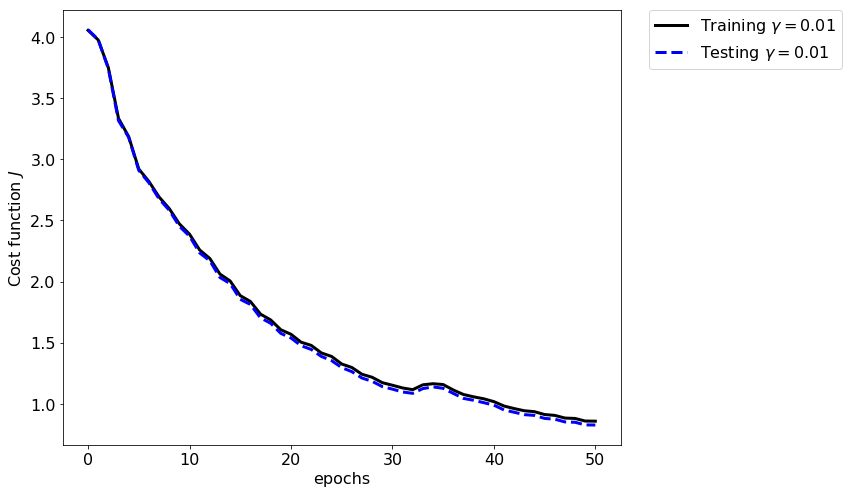

In [29]:
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history_train, ls='-', color = 'black', lw = 3, label = r'Training $\gamma = 0.01$')
ax.plot(cost_history_test, ls='--', color = 'blue', lw = 3, label = r'Testing $\gamma = 0.01$')

ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);